# Introduction

In this notebook we will be investigating Generative Adversarial Networks (GANs). We will birefly described their formulation, and then we will build a network to generate handwritten digits based on training from the MNIST dataset. Our model will not deviate too much from the classic setup for a GAN, although we will introduce a few more modern tweaks. I have used [this TensorFlow tutorial](https://www.tensorflow.org/tutorials/generative/dcgan) and [this Keras tutorial](https://keras.io/examples/generative/dcgan_overriding_train_step/) to help me in my work.

# Mathematical Setup

GANs are suprisingly straightforward, although they certainly can become much more complicated as one introduces more modifications or attempts to stabalize them in some way. The idea is that you train two networks simultaneously. One network is the generator which produces fake images, and the other netowrk is the discriminator which distinguishes between real and fake images.

For the generator we assume that it generates an image based on some latent input $z$ with prior distribution $p_z$. This pretty much brings us directly to the loss function for our model where G is the generator and D is the discriminator.

$$
\min_G\max_D \mathrm{E}_{x\sim p_{data}(x)}[\log D(x)] + \mathrm{E}_{z\sim p_{z}(z)}[\log(1-D(G(z))]
$$

Looking at the inner maximization we can see that we want the discriminator to correctly identify the real images as real and the fake images as fake. The minimization for the generator is then about fooling the descriminator into thinking that its generated images are real.

The only other major thing we need is the architecture of the generator and descriminator. This will be determined by the data, so let's move on to building a network.

# Building a Network

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

We went through the dataset a bit more extensively in the *Variational Auto-Encoder* notebook, so we will move through it quickly here. 

In [3]:
#Download
(train, _), (test, _) = keras.datasets.mnist.load_data()

imgs = np.concatenate((train, test), axis=0).astype('float32')
# labels = np.concatenate((train[1], test[1]), axis=0)

#Reshape and rescale
imgs = imgs.reshape((imgs.shape[0], 28, 28, 1))/255

#Turn into TF Dataset
from tensorflow.data.experimental import AUTOTUNE

size = imgs.shape[0]
batch_size = 256

dataset = (tf.data.Dataset.from_tensor_slices(imgs).shuffle(size)
           .batch(batch_size).prefetch(AUTOTUNE))

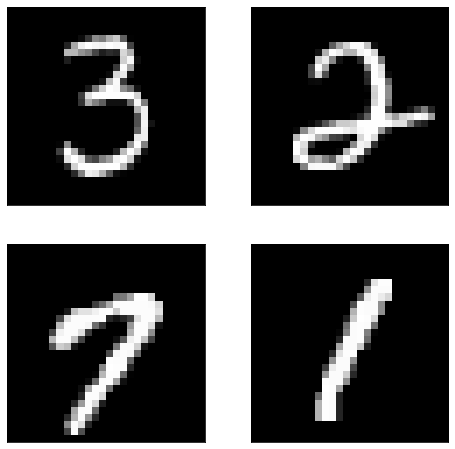

In [6]:
#Look at a picture
fig, ax = plt.subplots(2,2,figsize=(8,8))

for i in range(2):
    for j in range(2):
        ax[i,j].imshow(train[np.random.randint(1,100)], cmap='gray')

        ax[i,j].tick_params(axis='both', labelbottom=False, 
                       labelleft=False, bottom=False, left=False)

Now we will build our model. We set our latent dimension at 100 and our base number of filters is 32.

In [7]:
latent_dim = 100
base = 32

The generator is a transposed CNN.

In [8]:
generator = keras.Sequential([
    keras.layers.InputLayer(input_shape=(latent_dim,)),
    
    keras.layers.Dense(units=7*7*4*base, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('swish'),
    
    keras.layers.Reshape((7,7,4*base)),
    
    keras.layers.Conv2DTranspose(filters=4*base, kernel_size=3, 
                                strides=1, padding='same', 
                                use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('swish'),
    
    keras.layers.Conv2DTranspose(filters=2*base, kernel_size=3, 
                                strides=2, padding='same', 
                                use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('swish'),
    
    keras.layers.Conv2DTranspose(filters=base, kernel_size=3, 
                                strides=2, padding='same', 
                                use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('swish'),
    
    keras.layers.Conv2DTranspose(filters=1, kernel_size=3, 
                                strides=1, padding='same', 
                                use_bias=False, activation='sigmoid')
])

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              627200    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
activation (Activation)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         147456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)         0

The discriminator is a standard CNN.

In [9]:
discriminator = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28,28,1)),
    
    keras.layers.Conv2D(filters=base, kernel_size=3, strides=1, 
                        padding='same'),
    keras.layers.Activation('swish'),
    
    keras.layers.Conv2D(filters=2*base, kernel_size=3, strides=2, 
                        padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('swish'),
    
    keras.layers.Conv2D(filters=4*base, kernel_size=3, strides=2, 
                        padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('swish'),
    
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)        

The following subclasses a Keras model to allow us to implement the somewhat more complicated training procedure.

In [10]:
class GAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        
        self.G = generator
        self.D = discriminator
        self.latent_dim = latent_dim
        
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super().compile()
        
        self.g_optim = g_optimizer
        self.d_optim = d_optimizer
        self.loss_fn = loss_fn
        
        self.g_metric = keras.metrics.Mean(name='g_loss')
        self.d_metric = keras.metrics.Mean(name='d_loss')
        
    @property
    def metrics(self):
        return [self.g_metric, self.d_metric]
    
    @tf.function
    def train_step(self, real_imgs):
        batch_size = tf.shape(real_imgs)[0]
        
        noise = tf.random.normal((batch_size, self.latent_dim))
        
        labels = tf.concat([tf.zeros((batch_size,1)), 
                            tf.ones((batch_size,1))], axis=0)
        labels += 0.05*tf.random.uniform(tf.shape(labels))
        
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            gen_imgs = self.G(noise)
            
            imgs = tf.concat([gen_imgs, real_imgs], axis=0)
            
            predictions = self.D(imgs)
            
            g_loss = self.loss_fn(labels[batch_size:], 
                                  predictions[:batch_size])
            d_loss = self.loss_fn(labels, predictions)
            
        g_vars = self.G.trainable_variables
        d_vars = self.D.trainable_variables

        g_grad = g_tape.gradient(g_loss, g_vars)
        d_grad = d_tape.gradient(d_loss, d_vars)

        self.g_optim.apply_gradients(zip(g_grad, g_vars))
        self.d_optim.apply_gradients(zip(d_grad, d_vars))
        
        #Update metrics
        self.g_metric.update_state(g_loss)
        self.d_metric.update_state(d_loss)
        
        return {'g_loss': self.g_metric.result(), 
                'd_loss': self.d_metric.result()}

In [11]:
gan = GAN(generator, discriminator, latent_dim)
gan.compile(tf.keras.optimizers.Adam(1e-5), 
            tf.keras.optimizers.Adam(1e-4),
            keras.losses.BinaryCrossentropy(from_logits=True))

gan.fit(dataset, epochs=30)

Epoch 1/30
274/274 [==============================] - 40s 137ms/step - g_loss: 3.3623 - d_loss: -0.5269
Epoch 2/30
274/274 [==============================] - 39s 141ms/step - g_loss: 269.0355 - d_loss: -42.2445
Epoch 3/30
274/274 [==============================] - 40s 146ms/step - g_loss: 1787.2091 - d_loss: -42.9227
Epoch 4/30
274/274 [==============================] - 41s 148ms/step - g_loss: 1238.6931 - d_loss: -32.1834
Epoch 5/30
274/274 [==============================] - 41s 150ms/step - g_loss: 1543.6191 - d_loss: -9.3041
Epoch 6/30
274/274 [==============================] - 41s 151ms/step - g_loss: 751.7455 - d_loss: 9.6160
Epoch 7/30
274/274 [==============================] - 42s 154ms/step - g_loss: 431.4754 - d_loss: 0.6728
Epoch 8/30
274/274 [==============================] - 42s 154ms/step - g_loss: 315.0453 - d_loss: -3.5333
Epoch 9/30
274/274 [==============================] - 42s 154ms/step - g_loss: 253.2318 - d_loss: -4.8933
Epoch 10/30
274/274 [=======================

I was originally planning to train for 50 epochs, but that was taking too long, so I settled with 30.

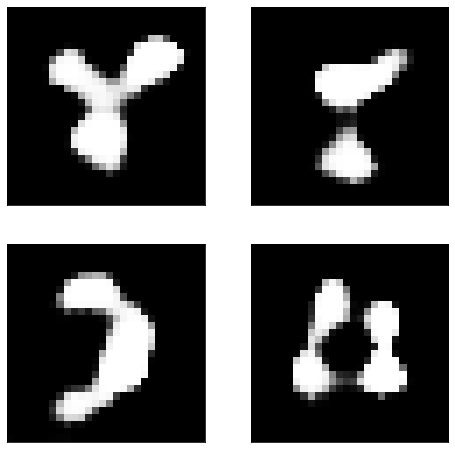

In [17]:
#Look at a picture
fig, ax = plt.subplots(2,2,figsize=(8,8))

for i in range(2):
    for j in range(2):
        noise = tf.random.normal((1, latent_dim))
        gen_x = gan.G.predict(noise).reshape((28,28,1))
        
        ax[i,j].imshow(gen_x, cmap='gray')

        ax[i,j].tick_params(axis='both', labelbottom=False, 
                       labelleft=False, bottom=False, left=False)

Hmmm, things aren't looking too good. I may need to train for longer, or perhaps my model setup isn't quite tuned correctly. Clearly the generator is learning something, but I will need to investigate more.